In [27]:
!pip3 install --upgrade gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics as m
import multiprocessing
from gensim.models.word2vec import Word2Vec
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
from gensim.models.phrases import Phrases, Phraser
import nltk
print(cores)
from time import time
import tensorflow as tf
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
print(tf.__version__)


Defaulting to user installation because normal site-packages is not writeable
4
2.4.0


In [41]:
dataset = pd.read_csv('/content/imbalanced_dataset_500.csv')
train, test = model_selection.train_test_split(dataset, test_size=0.3)
x_train = train["pre_processed_text"].values
x_test = test["pre_processed_text"].values
y_train = train["category"].values
y_test = test["category"].values
print("our training set contains %d examples"%(len(x_train)))
print("our test set contains %d examples"%(len(x_test)))

our training set contains 9879 examples
our test set contains 4235 examples


In [42]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
print(y_train)
print(y_test)
Y_train = np.array([inverse_dic[y] for y in y_train])
Y_test = np.array([inverse_dic[y] for y in y_test])
print(Y_train)
print(Y_test)

['Automotive' "Women'sClothing" 'Footwear' ... 'Jewellery' 'Jewellery'
 'BeautyandPersonalCare']
['BeautyandPersonalCare' "Women'sClothing" 'BeautyandPersonalCare' ...
 'BeautyandPersonalCare' 'Jewellery' 'BeautyandPersonalCare']
[ 0 12  3 ...  6  6  1]
[ 1 12  1 ...  1  6  1]


In [43]:
w2v_model = Word2Vec(vector_size = 300,window=8, min_count=1, sg=1,  workers=cores-1)
word_sentences = list()
for x in x_train:
    word_sentences.append(x.split())
t = time()
w2v_model.build_vocab(word_sentences, progress_per=100)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
print(len(word_sentences))

Time to build vocab: 0.01 mins
9879


In [44]:
t = time()

w2v_model.train(word_sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))


Time to train the model: 2.43 mins


In [45]:
w2v_model.wv.most_similar(positive=['girl'])

[('stichinggolden', 0.48919832706451416),
 ('hey', 0.464607298374176),
 ('specialviral', 0.4643440842628479),
 ('patialas', 0.46431633830070496),
 ('madden', 0.46205583214759827),
 ('viral', 0.4563966393470764),
 ('animated', 0.4540029466152191),
 ('dexterously', 0.449835866689682),
 ('hunger', 0.4436429738998413),
 ('hat', 0.44205334782600403)]

In [46]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(x_train)
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(x_train)
## padding sequence
  
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=600, padding="post", truncating="post")


In [47]:
lst_text2seq= tokenizer.texts_to_sequences(x_test)
## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=600, padding="post", truncating="post")


In [48]:

## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(w2v_model.wv.key_to_index)+2, 300))
for word,idx in w2v_model.wv.key_to_index.items():
    ## update the row with vector
    try:
        embeddings[idx] =  w2v_model.wv.get_vector(word)
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [49]:
print(embeddings.shape)
print(np.max(X_train))

(17148, 300)
17147


In [50]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

## input
x_in = layers.Input(shape=(600,))
## embedding
x = layers.Embedding(embeddings.shape[0],  
                     embeddings.shape[1],
                     weights=[embeddings],
                     input_length=600, trainable=False)(x_in)

l_cov1= layers.Conv1D(128, 3, activation='relu')(x)
l_pool1 = layers.MaxPooling1D(5)(l_cov1)
l_cov2 = layers.Conv1D(64, 3, activation='relu')(l_pool1)
l_pool2 = layers.MaxPooling1D(5)(l_cov2)
l_flat = layers.Flatten()(l_pool2)
## final dense layers
x = layers.Dense(64, activation='relu')(l_flat)
y_out = layers.Dense(13, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 600)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 600, 300)          5144400   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 598, 128)          115328    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 119, 128)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 117, 64)           24640     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1472)              0   

In [51]:
## train
training = model.fit(x=X_train, y=Y_train, batch_size=64, 
                     epochs=50, shuffle=True, verbose=2, callbacks=[callback],
                     validation_split=0.3)


Epoch 1/50
109/109 - 3s - loss: 1.4651 - accuracy: 0.5356 - val_loss: 0.6937 - val_accuracy: 0.8060
Epoch 2/50
109/109 - 2s - loss: 0.4040 - accuracy: 0.8895 - val_loss: 0.2681 - val_accuracy: 0.9339
Epoch 3/50
109/109 - 2s - loss: 0.1201 - accuracy: 0.9718 - val_loss: 0.1593 - val_accuracy: 0.9609
Epoch 4/50
109/109 - 2s - loss: 0.0493 - accuracy: 0.9920 - val_loss: 0.1368 - val_accuracy: 0.9642
Epoch 5/50
109/109 - 2s - loss: 0.0227 - accuracy: 0.9962 - val_loss: 0.1275 - val_accuracy: 0.9696
Epoch 6/50
109/109 - 2s - loss: 0.0313 - accuracy: 0.9933 - val_loss: 0.1545 - val_accuracy: 0.9609
Epoch 7/50
109/109 - 2s - loss: 0.0091 - accuracy: 0.9990 - val_loss: 0.1098 - val_accuracy: 0.9696
Epoch 8/50
109/109 - 2s - loss: 0.0043 - accuracy: 0.9996 - val_loss: 0.1051 - val_accuracy: 0.9740
Epoch 9/50
109/109 - 2s - loss: 0.0026 - accuracy: 0.9997 - val_loss: 0.1223 - val_accuracy: 0.9703
Epoch 10/50
109/109 - 2s - loss: 0.0019 - accuracy: 0.9999 - val_loss: 0.1084 - val_accuracy: 0.9733

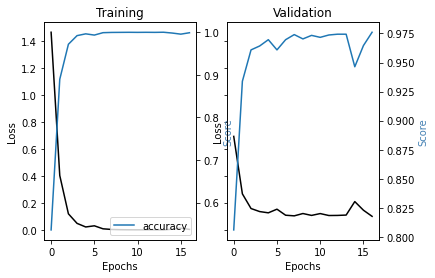

In [52]:
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

In [53]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]
predicted_vec = [ inverse_dic[p] for p in predicted]

In [ ]:
print(Y_test)
print(predicted)

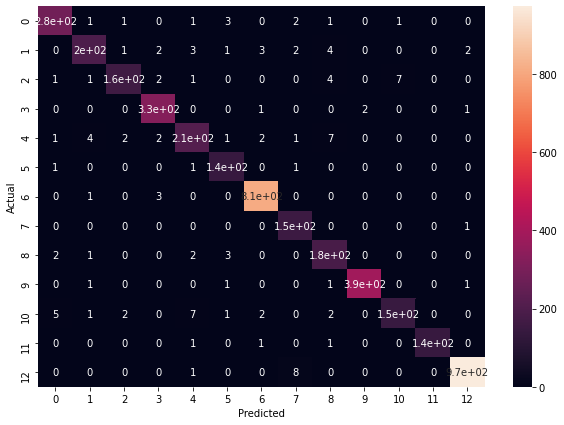

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       292
           1       0.95      0.92      0.93       215
           2       0.96      0.91      0.94       178
           3       0.97      0.99      0.98       330
           4       0.93      0.91      0.92       233
           5       0.93      0.98      0.96       144
           6       0.99      1.00      0.99       813
           7       0.92      0.99      0.95       153
           8       0.90      0.96      0.93       192
           9       0.99      0.99      0.99       393
          10       0.95      0.88      0.91       167
          11       1.00      0.98      0.99       144
          12       0.99      0.99      0.99       981

    accuracy                           0.97      4235
   macro avg       0.96      0.96      0.96      4235
weighted avg       0.97      0.97      0.97      4235



In [54]:
conf_mat = m.confusion_matrix(Y_test, predicted_vec,normalize = None)
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# target_strings = encoder.inverse_transform(np.arange(20))

print(m.classification_report(Y_test, predicted_vec))

In [26]:
dic_y_mapping[6]

NameError: name 'dic_y_mapping' is not defined